In [ ]:
!pip install PyPDF2
!pip install spacy
!python -m spacy download de_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import re
import spacy
import pandas as pd
import numpy as np
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from tqdm import tqdm
from datetime import date
import time
import itertools
import collections
from collections import Counter

In [ ]:
from PyPDF2 import PdfReader

## Artikel in geordnete Form bringen

### Text aus PDFs extrahieren

In [ ]:
# Funktion zum Lesen von Daten in einer .txt-Datei
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        text = f.read()
    return text

# Funktion zum Schreiben von Daten in eine .txt-Datei
def write_data(file, text):
    with open(file, "w", encoding="utf-8") as f:
        f.write(text)

In [ ]:
# Schritt 1: PDF-Dateien öffnen und gesamten Text extrahieren
text = ""

pdf_directory = r"D:\Datensatz\Handelsblatt"  # Auf Verzeichnis anpassen

# Durchlaufen aller PDF-Dateien (durchnummeriert von Dokument1.pdf bis Dokument36.pdf)
for i in range(1, 37):
    pdf_filename = f"Dokument{i}.pdf"
    pdf_path = os.path.join(pdf_directory, pdf_filename)

    # Prüfe, ob die Datei existiert
    if os.path.exists(pdf_path):
        print(f"Verarbeite {pdf_filename}...")
        with open(pdf_path, "rb") as pdf_file:
            reader = PdfReader(pdf_file)
            # Extrahiere Text aus allen Seiten
            for page in reader.pages:
                text += page.extract_text() + "\n"
    else:
        print(f"Warnung: {pdf_filename} wurde nicht gefunden.")

# Speichern des gesamten Texts in einer .txt-Datei
output_file = "extrahierter_text.txt"
write_data(output_file, text)
print(f"Text aus allen PDFs wurde in {output_file} gespeichert.")

### Anpassen der Artikel

Anpassen des Datumsformats, sodass es für alle Artikel identisch ist.

In [ ]:
text = load_data('extrahierter_text.txt')

# Schritt 2: Datumsformat ändern (zweistellige Jahreszahlen in vierstellige umwandeln)
def convert_short_year(match):
    day, month, year = match.groups()
    year = '20' + year if int(year) <= 50 else '19' + year
    return f"{day}.{month}.{year}"

pattern = r"(\d{2})\.(\d{2})\.(\d{2})(?=\s|[^0-9])"
text = re.sub(pattern, convert_short_year, text)  # `text` wird aktualisiert

Unnötige Textteile entfernen.

In [ ]:
print(f'Der Term "Handelsblatt print:" kommt vor dem Bereinigen {text.count("Handelsblatt print:")} mal vor.')

# Schritt 3: Entfernen des Texts zwischen den alternativen Quellenangaben und dem nächsten "Handelsblatt print:" oder bis zum Ende des Dokuments
pattern = r"(Quelle Handelsblatt print:|Quelle Verlagsbeilage im Handelsblatt print:).*?(?=Handelsblatt print:|$)"
text = re.sub(pattern, "", text, flags=re.DOTALL)

# Schritt 4: Entfernen von allem zwischen "Handelsblatt print:" und "vom", aber behalte "Handelsblatt print:" und "vom" selbst bei
pattern = r"(Handelsblatt print:).*?vom"
text = re.sub(pattern, r"\1 vom", text, flags=re.DOTALL)

# Schritt 5: Entfernen von allem von "Seite  von" bis zum nächsten Buchstaben
pattern = r"Seite  von [0-9\s]+(?=[a-zA-ZäöüÄÖÜß])"
text = re.sub(pattern, "", text, flags=re.DOTALL)

# Schritt 6: Entfernen von groß geschriebenen Wörtern, die länger als 4 Zeichen sind
def remove_uppercase_words(text):
    pattern = r'\b[A-ZÄÖÜ]{5,}\b'
    text = re.sub(pattern, '', text)
    return text

# Funktion zur Bereinigung des Textes
def clean_text_spacing(text):
    # Entferne überflüssige Zeilenumbrüche oder doppelte Leerzeichen
    text = re.sub(r"\s+", " ", text).strip()
    return text

text = remove_uppercase_words(text)
text = clean_text_spacing(text)

# Zählen des Vorkommen von "Handelsblatt print:" nach der Bereinigung (Kontrolle)
occurrences = text.count("Handelsblatt print:")
print(f'Der Begriff "Handelsblatt print:" kommt {occurrences} Mal im bereinigten Text vor.')

# Speichern des geänderten Texts wieder in einer .txt Datei
write_data('bereinigter_text.txt', text)

### Speichern in einer .csv Datei

In [ ]:
import csv
import string

In [ ]:
text = load_data('bereinigter_text.txt')

# Schritt 1: Artikel und Daten extrahieren
articles = re.split(r"Handelsblatt print: vom ", text)[1:]  # Splitte anhand des Keywords und ignoriere den ersten Teil
data = []

def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Schritt 2: Durch Artikel interieren und Datum und Text extrahieren
for article in articles:
    # Extrahieren des Datums (ersten 10 Zeichen)
    date = article[:10]
    if re.match(r"\d{2}\.\d{2}\.\d{4}", date):
        # Extrahieren des restlichen Texts
        text = article[10:].strip()
        # Entfernen des Teils vor dem nächsten "Handelsblatt print:" oder bis zum Ende
        text = re.split(r"Handelsblatt print: vom \d{2}\.\d{2}\.\d{4}", text, maxsplit=1)[0].strip()
        # Datum hinzufügen
        data.append({"Datum": date, "Text": text})

for article_data in data:
    article_data['Text'] = remove_punctuation(article_data['Text'])

# Schritt 3: DataFrame erstellen
df = pd.DataFrame(data)

Entfernen von doppelten Artikeln.

In [ ]:
def remove_duplicate_articles(df):
    # Erstellen einer Hilfsspalte für den Vergleich (Kombination aus Datum und ersten 100 Zeichen)
    df['duplicate_key'] = df['Datum'].astype(str) + '_' + df['Text'].str[:100]

    # Entfernen von Duplikaten basierend auf der Hilfsspalte
    df = df[~df.duplicated(subset='duplicate_key')].copy()

    # Entfernen der Hilfsspalte
    df.drop(columns=['duplicate_key'], inplace=True)

    # Index zurücksetzen
    df.reset_index(drop=True, inplace=True)

    return df

df = remove_duplicate_articles(df)

In [ ]:
print(len(df))

25180


Begrenzen auf Artikel mit mehr als 200 Wörtern.

In [ ]:
# Funktion zur Zählung der Wörter in einem Artikel
def word_count(text):
    return len(str(text).split())

# Zählen der Wörter und filtern der Artikel mit mindestens 200 Wörtern
df['Word Count'] = df['Text'].apply(word_count)
df_filtered = df[df['Word Count'] >= 200].drop(columns=['Word Count'])  # Entfernen der Hilfsspalte 'Word Count'

print(len(df_filtered))

NameError: name 'df' is not defined

DataFrame als .csv abspeichern.

In [ ]:
df_filtered.to_csv('artikel_tabelle.csv', index=False, encoding="utf-8")

## Lemmatisieren und Stoppwörter entfernen
1. Lemmatisieren des Textes
2. Umlaute umwandeln
3. Sonderzeichen und Bindestriche entfernen
4. Standard Stoppwörter entfernen
5. Text kleinschreiben

**Dieser Abschnitt des Codes ist stark am Code von Latifi et al. (2024) orientiert. Dieser ist hier zu finden:**
https://github.com/albi-lt/Fiscal-Policy-in-the-Bundestag/tree/main

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Benötigte Funktionen.

In [ ]:
def convert_umlauts(dataframe,textcolumn):
    dataframe[textcolumn].replace('Ä','AE',regex=True, inplace = True)
    dataframe[textcolumn].replace('ä','ae',regex=True, inplace = True)
    dataframe[textcolumn].replace('Ü','UE',regex=True, inplace = True)
    dataframe[textcolumn].replace('ü','ue',regex=True, inplace = True)
    dataframe[textcolumn].replace('Ö','OE',regex=True, inplace = True)
    dataframe[textcolumn].replace('ö','oe',regex=True, inplace = True)
    dataframe[textcolumn].replace('ß','ss',regex=True, inplace = True)

    return dataframe

def convert_umlauts_strings(texts):
    mapping = {ord(u"Ü"): u"Ue", ord(u"ü"): u"ue", ord(u"ß"): u"ss", ord(u"ä"): u"ae", ord(u"Ä"): u"Ae",
               ord(u"ö"): u"oe", ord(u"Ö"): u"Oe"}
    converted_texts = [i.translate(mapping) for i in texts]

    return converted_texts

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True,max_len = 30))
        #exclude tokens with one character and those with more than 30 characters

def remove_words(texts,words):
    docs = []
    for doc in tqdm(texts):
        doc_cleaned = list(filter(lambda word: word.lower() not in words, doc.split()))
        docs.append(' '.join(doc_cleaned))
    return docs

def remove_stopwords(texttoken,stopwordslist):
    filtered_text = [word for word in texttoken if word.lower() not in stopwordslist]
    return filtered_text

def lemmatize_texts(texts, spacy_model):
    nlp_model = spacy.load(spacy_model)
    pp = []
    print('Start lemmatization...')
    t0 = time.time()
    for i in tqdm(range(len(texts))):
        text = " ".join([token.lemma_ for token in nlp_model(texts[i])])#
        pp.append(text)
    t1 = time.time()
    print('Finished lemmatization. Process took', t1 - t0, 'seconds')
    return pp

def remove_specific_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in lemmatized_stopwords]
    return ' '.join(filtered_words)

In [ ]:
# Artikel einlesen
data = pd.read_csv('artikel_tabelle.csv')
data['länge_vorher'] = [len(i.split()) for i in data.Text]

### Lemmatisieren

In [ ]:
# Lemmatisieren der Texte
lemmatized = lemmatize_texts([data.Text[i] for i in range(data.shape[0])], 'de_core_news_lg')

# Erstellen einer neuen Spalte mit den lemmatisierten Texten
data['lemmatized_text'] = lemmatized

# Ersetzen von Zeilenumbrüchen innerhalb von Wörtern
data_lemmatized = data.replace('-\n', '', regex=True)

data_lemmatized[['Datum', 'länge_vorher', 'lemmatized_text']].to_csv('lemmatisierte_artikel.csv', index=False, encoding="utf-8")

Start lemmatization...


100%|██████████| 23681/23681 [56:59<00:00,  6.92it/s]


Finished lemmatization. Process took 3419.946244239807 seconds


### Entfernen von nltk-Stoppwörtern

In [ ]:
data_lemmatized = pd.read_csv('lemmatisierte_artikel.csv')
# Umlaute umschreiben
data_lemmatized['lemmatized_text'] = convert_umlauts_strings(data_lemmatized['lemmatized_text'])
# Spezielle Satzzeichen entfernen, einzelne Buchstaben und Zeichenketten mit mehr als 30 Buchstaben entfernen
data_lemmatized['lemmatized_text'] = [' '.join(words) for words in sent_to_words(data_lemmatized['lemmatized_text'])]

In [ ]:
print(data_lemmatized[['lemmatized_text']].head())

                                     lemmatized_text
0  politik homo wachstum sein der gut schuldenbre...
1  politik wachsende kritik und forderung fehlend...
2  politik green bonds statt eegumlage der regier...
3  special der sofortabschreibung digital wirtsch...
4  politik wir erwarten ein stufenplan der praesi...


In [ ]:
# Standard-Stoppwörter von nltk entfernen
data_lemmatized['text_preprocessed'] = remove_words(data_lemmatized['lemmatized_text'], convert_umlauts_strings(stop_words))

# Wörter zählen
gesamt_wörter_nachher = data_lemmatized['text_preprocessed'].apply(lambda x: len(str(x).split())).sum()
gesamt_wörter_vorher = data_lemmatized['lemmatized_text'].apply(lambda x: len(str(x).split())).sum()

# Ergebnisse ausgeben
entfernte_wörter = gesamt_wörter_vorher - gesamt_wörter_nachher
print(f"Vor der Entfernung spezifischer Stoppwörter umfasste der Datensatz {gesamt_wörter_vorher} Wörter.")
print(f"Durch die Entfernung entfielen {entfernte_wörter} Wörter.")
print(f"Somit umfasst der Korpus jetzt noch {gesamt_wörter_nachher} Wörter.")

100%|██████████| 23681/23681 [00:55<00:00, 429.06it/s]


Vor der Entfernung spezifischer Stoppwörter umfasste der Datensatz 15114608 Wörter.
Durch die Entfernung entfielen 6567451 Wörter.
Somit umfasst der Korpus jetzt noch 8547157 Wörter.


Speichern der bereinigten Texte.

In [ ]:
text_length_lemmatized = [len(i.split()) for i in data_lemmatized.text_preprocessed] # Textlänge nach dem Bereinigen der Artikel

data_lemmatized['länge_bereinigt'] = text_length_lemmatized

# Datum in datetime Format umwandeln
data_lemmatized['Datum'] = pd.to_datetime(data_lemmatized['Datum'], format='%d.%m.%Y')

# Extrahieren von Jahr und Quartal aus dem Datum
data_lemmatized['datum_jahr'] = data_lemmatized['Datum'].dt.year
data_lemmatized['datum_quartal'] = data_lemmatized['Datum'].dt.quarter

# Speichern in einer neuen .csv Datei
data_lemmatized[['Datum', 'datum_jahr', 'datum_quartal', 'text_preprocessed', 'länge_vorher', 'länge_bereinigt']].to_csv(
    'bereinigte_artikel.csv',
    index=False
)

In [ ]:
data_lemmatized[['Datum', 'datum_jahr', 'datum_quartal', 'text_preprocessed', 'länge_vorher', 'länge_bereinigt']]

,Datum,datum_jahr,datum_quartal,text_preprocessed,länge_vorher,länge_bereinigt
0,2021-02-16,2021,1,politik homo wachstum gut schuldenbremse kredi...,427,236
1,2021-02-16,2021,1,politik wachsende kritik forderung fehlend oef...,989,569
2,2021-02-16,2021,1,politik green bonds statt eegumlage regierung ...,1260,692
3,2021-02-16,2021,1,special sofortabschreibung digital wirtschafts...,201,114
4,2021-02-16,2021,1,politik erwarten stufenplan praesident verband...,809,428
...,...,...,...,...,...,...
23676,2000-11-13,2000,4,seite deu tschland vertraulicher rechnungshofb...,677,358
23677,2000-11-13,2000,4,seite deu tschland vorsitzend sonderausschuss ...,459,243
23678,2000-11-10,2000,4,seite deu tschland kommentar eichel vision fer...,365,202
23679,2000-11-10,2000,4,seite deu tschland grundsatzrede bundesﬁnanzmi...,771,427


### Entfernen spezifischer Stoppwörter
Die Stoppwörter basieren auf der Liste von Latifi et al., (2024) und wurden manuell angepasst.

In [ ]:
# Schritt 1: Einlesen der CSV mit spezifischen Stoppwörtern
stopwords_df = pd.read_csv('self_filtered_stopwords_german_bundestag.csv', header=None)

# Schritt 2: Extrahieren der lemmatisierten Stoppwörter aus der Tabelle
lemmatized_stopwords = stopwords_df[2].drop(0).tolist()

# Wörter vor der Entfernung spezifischer Stoppwörter zählen
gesamt_wörter_vorher = data_lemmatized['text_preprocessed'].apply(lambda x: len(str(x).split())).sum()

# Anwenden der Funktion auf die Spalte 'text_preprocessed'
data_lemmatized['text_preprocessed_specific'] = data_lemmatized['text_preprocessed'].apply(remove_specific_stopwords)

# Wörter nach der Entfernung spezifischer Stoppwörter zählen
gesamt_wörter_nachher = data_lemmatized['text_preprocessed_specific'].apply(lambda x: len(str(x).split())).sum()

# Schritt 6: Ergebnisse ausgeben
entfernte_wörter = gesamt_wörter_vorher - gesamt_wörter_nachher
print(f"Vor der Entfernung spezifischer Stoppwörter umfasste der Datensatz {gesamt_wörter_vorher} Wörter.")
print(f"Durch die Entfernung entfielen {entfernte_wörter} Wörter.")
print(f"Somit umfasst der Korpus jetzt noch {gesamt_wörter_nachher} Wörter.")

Vor der Entfernung spezifischer Stoppwörter umfasste der Datensatz 8547157 Wörter.
Durch die Entfernung entfielen 2217274 Wörter.
Somit umfasst der Korpus jetzt noch 6329883 Wörter.


In [ ]:
text_length_specific = [len(i.split()) for i in data_lemmatized.text_preprocessed_specific] # Textlänge nach dem Bereinigen der Artikel

data_lemmatized['länge_bereinigt_spezifisch'] = text_length_specific

# Speichern in einer neuen .csv Datei
data_lemmatized[['Datum', 'datum_jahr', 'datum_quartal', 'text_preprocessed_specific', 'länge_vorher', 'länge_bereinigt', 'länge_bereinigt_spezifisch']].to_csv(
    'bereinigte_artikel_spezifisch.csv',
    index=False
)

## Graphische Darstellung

In [ ]:
import matplotlib.pyplot as plt

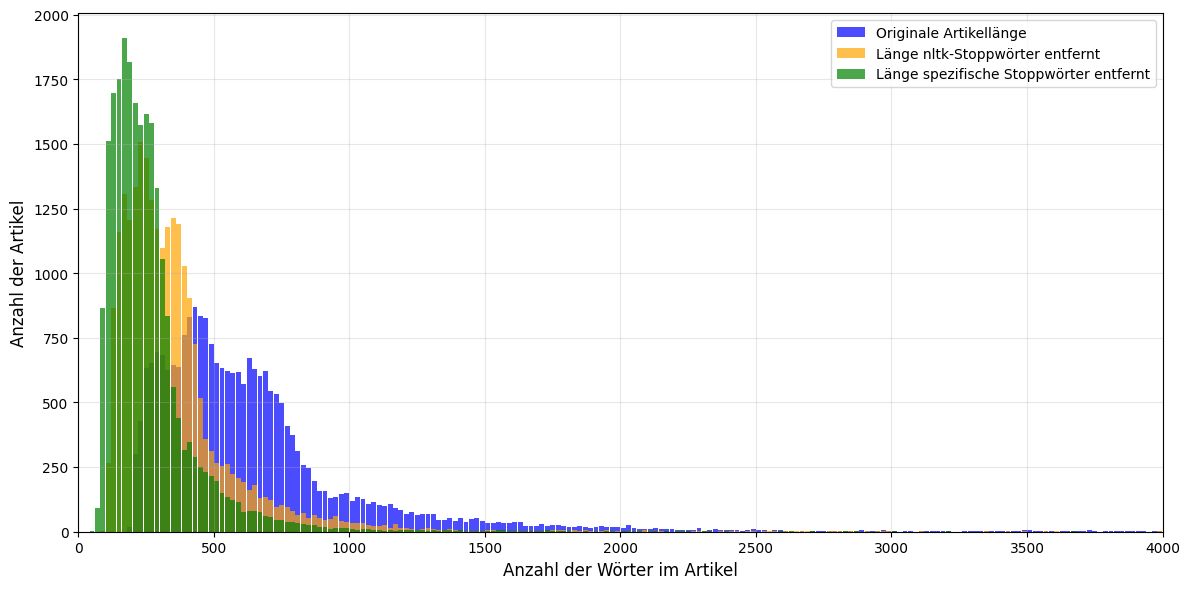

In [ ]:
data_lemmatized = pd.read_csv('bereinigte_artikel_spezifisch.csv')

# Definieren von Bins für Gruppen von 20 Tokens
bin_edges = range(0, data_lemmatized["länge_vorher"].max() + 20, 20)

# Frequenzberechnung für jede Textlängenspalte
freq_original = pd.cut(data_lemmatized["länge_vorher"], bins=bin_edges).value_counts().sort_index()
freq_nltk = pd.cut(data_lemmatized["länge_bereinigt"], bins=bin_edges).value_counts().sort_index()
freq_specific = pd.cut(data_lemmatized["länge_bereinigt_spezifisch"], bins=bin_edges).value_counts().sort_index()

# Mittelpunkte der Bins
bin_midpoints = [interval.mid for interval in freq_original.index.categories]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(bin_midpoints, freq_original, width=18, label="Originale Artikellänge", alpha=0.7, color='blue')
plt.bar(bin_midpoints, freq_nltk, width=18, label="Länge nltk-Stoppwörter entfernt", alpha=0.7, color='orange')
plt.bar(bin_midpoints, freq_specific, width=18, label="Länge spezifische Stoppwörter entfernt", alpha=0.7, color='green')

# Achsenbeschriftungen und Titel
plt.xlabel("Anzahl der Wörter im Artikel", fontsize=12)
plt.ylabel("Anzahl der Artikel", fontsize=12)
# plt.title("", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
# Begrenze die x-Achse auf 4000 Wörter
plt.xlim(0, 4000)
plt.tight_layout()

# Speichern der Grafik
plt.savefig('EDA_artikel_1.png', format='png', dpi=600)

plt.show()